In [1]:
import matplotlib.pyplot as plt
import numpy as np

PLOT_COLORS = ["red", "green", "blue", "orange"]  
K = 4           # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run 
UNLABELED = -1  # Cluster label for unlabeled data points 

In [2]:
def load_gmm_dataset(csv_path):

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    z_cols = [i for i in range(len(headers)) if headers[i] == 'z']

    x = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols, dtype=float)
    z = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=z_cols, dtype=float)

    if z.ndim == 1:
        z = np.expand_dims(z, axis=-1)

    return x, z

In [3]:
def run_em(x, w, phi, mu, sigma):
    """Problem 3(d): EM Algorithm (unsupervised).
        x: Design matrix of shape (m, n).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """

    eps = 1e-3  # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    it = 0
    ll = prev_ll = None

    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        # By log-likelihood, we mean ll = sum_x[log(sum_z[p(x|z) * p(z)])].
        # We define convergence by the first iteration where abs(ll - prev_ll) < eps.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        prev_ll = ll



        def gaussian(x, mu, sigma):
            """
            - x: (m, n)
            - mu: (n)
            - sigma :(n, n)
            """
            from numpy.linalg import pinv, det
            from numpy import matmul as mm
            from numpy import pi, sqrt, power, exp
            m, n = x.shape

            # reshape for convenience
            # x (m, n, 1) mu (n, 1)
            x = x[:, :, None]
            mu = mu[:, None]

            x_T = x.transpose(0, 2, 1)
            mu_T = mu.T
            # (m, 1, 1) -> (m)
            term = -0.5 * mm(x_T - mu_T, mm(pinv(sigma), x - mu))[:, 0, 0]

            return (1 / (power(2 * pi, n / 2) * sqrt(det(sigma) )) * exp(term))



        # x(m,n), mu(n), sigma(n,n)
        # loop over k to update w
        m, n = x.shape
        k = len(mu)
        for j, (mu_j, sigma_j) in enumerate(zip(mu, sigma)):
            w[:, j] = gaussian(x, mu_j, sigma_j) * phi[j]

        # normalize
        w = w / w.sum(axis=1, keepdims=True)

        # update mu and sigma
        for j in range(k):
            mu[j] = w[:, j].dot(x) / w[:, j].sum()
            # (n, n)
            sigma[j] = (x - mu[j]).T.dot(np.diag(w[:, j])).dot(x - mu[j]) / w[:, j].sum()
        phi = w.sum(axis=0)
        # normalize
        phi = phi / phi.sum()

        # compute log likelihood
        p_x = np.zeros(m)
        for j in range(k):
            # (m,)
            p_x_given_z =  gaussian(x, mu[j], sigma[j])
            p_x += p_x_given_z * phi[j]

        ll = np.sum(np.log(p_x))
        it += 1
        print('Iter {}, Likelihood {}'.format(it, ll))

    return w

In [4]:

def run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma):
    """
    Args:
        x: Design matrix of unlabeled examples of shape (m, n).
        x_tilde: Design matrix of labeled examples of shape (m_tilde, n).
        z: Array of labels of shape (m_tilde, 1).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """

    alpha = 20.  # Weight for the labeled examples
    eps = 1e-3   # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    it = 0
    ll = prev_ll = None

    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        prev_ll = ll



        def gaussian(x, mu, sigma):
            """
            - x: (m, n)
            - mu: (n)
            - sigma :(n, n)
            """
            from numpy.linalg import pinv, det
            from numpy import matmul as mm
            from numpy import pi, sqrt, power, exp
            m, n = x.shape
            
            # reshape for convenience
            # x (m, n, 1) mu (n, 1)
            x = x[:, :, None]
            mu = mu[:, None]
            
            x_T = x.transpose(0, 2, 1)
            mu_T = mu.T
            # (m, 1, 1) -> (m)
            term = -0.5 * mm(x_T - mu_T, mm(pinv(sigma), x - mu))[:, 0, 0]

            return (1 / (power(2 * pi, n / 2) * sqrt(det(sigma) )) * exp(term))




        # x (m, n), mu (n), sigma (n, n)
        # loop over k to update w
        m, n = x.shape
        m_tilde, n = x_tilde.shape
        k = len(mu)
        # w_tilde: (m_tilde, k) indicator
        w_tilde = np.zeros((m_tilde, k))
        for j, (mu_j, sigma_j) in enumerate(zip(mu, sigma)):
            w[:, j] = gaussian(x, mu_j, sigma_j) * phi[j]
            w_tilde[:, j] = (z == j).squeeze()
        # normalize
        w = w / w.sum(axis=1, keepdims=True)

        # update mu and sigma
        for j in range(k):
            mu[j] = (w[:, j].dot(x) + alpha * w_tilde[:, j].dot(x_tilde))/ (w[:, j].sum() + alpha * w_tilde[:, j].sum())
            # (n, n)
            sigma[j] = (
                ((x - mu[j]).T.dot(np.diag(w[:, j])).dot(x - mu[j]) + alpha * (x_tilde - mu[j]).T.dot(np.diag(w_tilde[:, j])).dot(x_tilde - mu[j])) /
                (w[:, j].sum() + alpha * w_tilde[:, j].sum())
            )
        phi = (w.sum(axis=0) + alpha * w_tilde.sum(axis=0))
        phi = phi / phi.sum()

        # compute log likelihood
        p_x = np.zeros(m)
        for j in range(k):
            # (m,)
            p_x_given_z =  gaussian(x, mu[j], sigma[j])
            p_x += p_x_given_z * phi[j]
        p_x_z = np.zeros(m_tilde)
        for j in range(k):
            p_x_z += gaussian(x_tilde, mu[j], sigma[j]) * phi[j]

        ll = np.sum(np.log(p_x)) + alpha * np.sum(np.log(p_x_z))
        it += 1
        print('Iter {}, Likelihood {}'.format(it, ll))

    return w

In [5]:
def plot_gmm_preds(x, z, with_supervision, plot_id):

    plt.figure(figsize=(12, 8))
    plt.title('{} GMM Predictions'.format('Semi-supervised' if with_supervision else 'Unsupervised'))
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)
    plt.show()

In [6]:
def main(is_semi_supervised, trial_num):
    """Problem 3: EM for Gaussian Mixture Models (unsupervised and semi-supervised)"""
    print('Running {} EM algorithm...'
          .format('semi-supervised' if is_semi_supervised else 'unsupervised'))

    # Load dataset
    #with open("/content/drive/My Drive/Colab Notebooks/CS229/ps2/output/p06_dictionary", "w") as f:

    train_path = "/content/drive/My Drive/Colab Notebooks/CS229/ps3/data/ds3_train.csv"
    x, z = load_gmm_dataset(train_path)
    x_tilde = None

    if is_semi_supervised:
        # Split into labeled and unlabeled examples
        labeled_idxs = (z != UNLABELED).squeeze()
        x_tilde = x[labeled_idxs, :]   # Labeled examples
        z = z[labeled_idxs, :]         # Corresponding labels
        x = x[~labeled_idxs, :]        # Unlabeled examples


    # (1) Initialize mu and sigma by splitting the m data points uniformly at random
    # into K groups, then calculating the sample mean and covariance for each group
    
    # (2) Initialize phi to place equal probability on each Gaussian
    # phi should be a numpy array of shape (K,)

    # (3) Initialize the w values to place equal probability on each Gaussian
    # w should be a numpy array of shape (m, K)

    # x (m, K) 
    m = x.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    # find the K groups
    groups = np.array_split(x[indices], K, axis=0)

    mu = []
    sigma = []
    for g in groups:
        # g (m, K) mu (K)
        this_mu = g.mean(axis=0)
        this_sigma = (x - this_mu).T.dot(x - this_mu) / g.shape[0]
        mu.append(this_mu)
        sigma.append(this_sigma)

    phi = np.ones(K) / K
    w = np.ones((m, K)) / K


    if is_semi_supervised:
        w = run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w = run_em(x, w, phi, mu, sigma)

    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])

    plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)

Running unsupervised EM algorithm...
Iter 1, Likelihood -2450.6380601841365
Iter 2, Likelihood -2447.807119138005
Iter 3, Likelihood -2429.8225318878895
Iter 4, Likelihood -2369.919772715666
Iter 5, Likelihood -2258.3067958194965
Iter 6, Likelihood -2130.2877741601806
Iter 7, Likelihood -2041.539932609257
Iter 8, Likelihood -2003.4420947002843
Iter 9, Likelihood -1991.3114746823924
Iter 10, Likelihood -1986.1186039394056
Iter 11, Likelihood -1981.4813630065016
Iter 12, Likelihood -1975.373706700035
Iter 13, Likelihood -1966.4439046951688
Iter 14, Likelihood -1952.946122066008
Iter 15, Likelihood -1932.6585616129412
Iter 16, Likelihood -1904.8302104908971
Iter 17, Likelihood -1875.4311269115663
Iter 18, Likelihood -1856.5507560179465
Iter 19, Likelihood -1849.8544184896116
Iter 20, Likelihood -1847.9668833332871
Iter 21, Likelihood -1847.257206690867
Iter 22, Likelihood -1846.8537134583796
Iter 23, Likelihood -1846.5590027486382
Iter 24, Likelihood -1846.3245676098584
Iter 25, Likelihoo

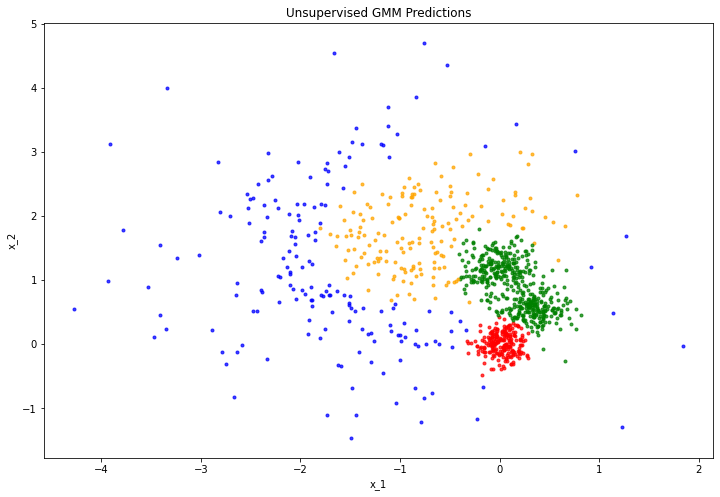

Running unsupervised EM algorithm...
Iter 1, Likelihood -2450.623833919727
Iter 2, Likelihood -2447.8233628918742
Iter 3, Likelihood -2428.1654604856585
Iter 4, Likelihood -2360.5375994114393
Iter 5, Likelihood -2253.5347913515366
Iter 6, Likelihood -2140.9988047596266
Iter 7, Likelihood -2054.336745958091
Iter 8, Likelihood -2010.5737773286928
Iter 9, Likelihood -1993.1650762094982
Iter 10, Likelihood -1984.5445942332417
Iter 11, Likelihood -1977.4862421901028
Iter 12, Likelihood -1969.098314221792
Iter 13, Likelihood -1957.4184813875866
Iter 14, Likelihood -1940.6317269107456
Iter 15, Likelihood -1918.140107385625
Iter 16, Likelihood -1892.0687796853272
Iter 17, Likelihood -1868.2949792444965
Iter 18, Likelihood -1854.7210908457596
Iter 19, Likelihood -1850.1701334034317
Iter 20, Likelihood -1848.868348200192
Iter 21, Likelihood -1848.3949146635591
Iter 22, Likelihood -1848.1454373953234
Iter 23, Likelihood -1847.9589926332146
Iter 24, Likelihood -1847.7840164172683
Iter 25, Likeliho

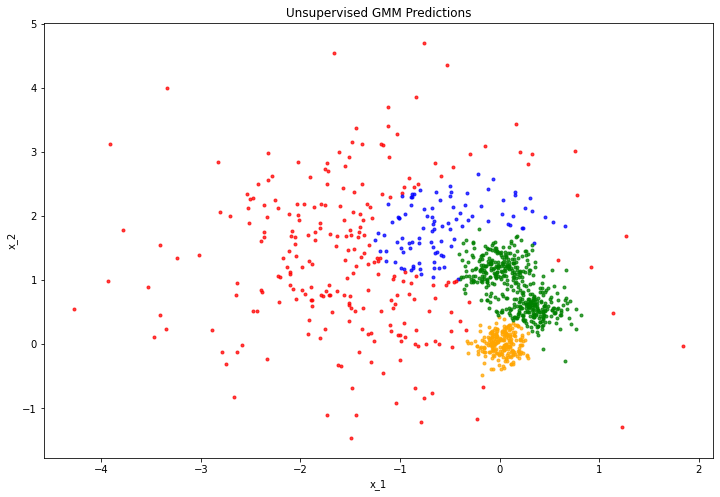

Running unsupervised EM algorithm...
Iter 1, Likelihood -2450.927679354419
Iter 2, Likelihood -2450.365639297629
Iter 3, Likelihood -2445.966516083041
Iter 4, Likelihood -2421.4681788284006
Iter 5, Likelihood -2354.9350797111074
Iter 6, Likelihood -2249.2531845831395
Iter 7, Likelihood -2128.2712003863317
Iter 8, Likelihood -2041.4910757383668
Iter 9, Likelihood -2004.7294398404847
Iter 10, Likelihood -1990.8238967679117
Iter 11, Likelihood -1983.5592097958056
Iter 12, Likelihood -1977.5133576504059
Iter 13, Likelihood -1970.6536299230777
Iter 14, Likelihood -1961.8762563146533
Iter 15, Likelihood -1950.8527840181507
Iter 16, Likelihood -1938.244658900723
Iter 17, Likelihood -1924.3847605864598
Iter 18, Likelihood -1908.0531736337093
Iter 19, Likelihood -1888.0764067202558
Iter 20, Likelihood -1867.8702342834067
Iter 21, Likelihood -1855.1679856678752
Iter 22, Likelihood -1850.3800979742878
Iter 23, Likelihood -1848.8219942387796
Iter 24, Likelihood -1848.1913267146683
Iter 25, Likelih

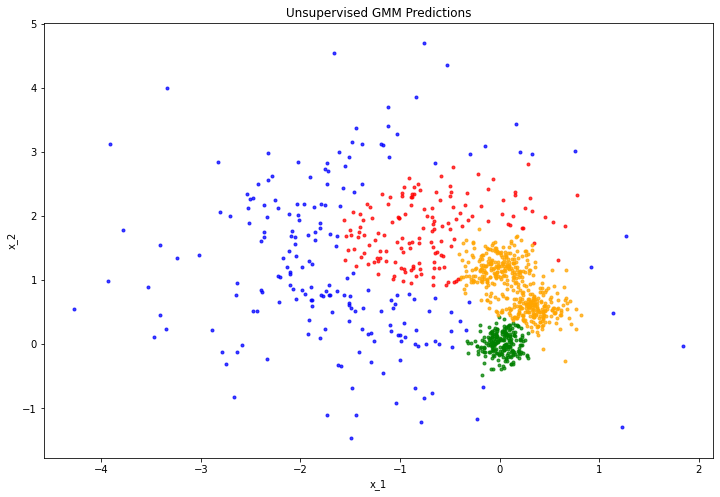

In [7]:
np.random.seed(42)
for t in range(NUM_TRIALS):
    main(is_semi_supervised=False, trial_num=t)
    #main(is_semi_supervised=True, trial_num=t)